<a href="https://colab.research.google.com/github/heghiw/lakovaci-linka/blob/main/fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install pulp
import pandas as pd


import pandas as pd
import numpy as np
import pulp

In [14]:
# Remove the existing directory
!rm -rf lakovaci-linka

# Clone the repository again
!git clone https://github.com/heghiw/lakovaci-linka.git

# Navigate to the directory
%cd lakovaci-linka


Cloning into 'lakovaci-linka'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 110 (delta 48), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 9.43 MiB | 14.24 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/lakovaci-linka/lakovaci-linka


data prep

In [15]:
# Define the path to the Excel file
file_path = '/content/lakovaci-linka/data1.xlsx'

# Read the sheet 'linka' into a DataFrame
linka_df = pd.read_excel(file_path, sheet_name='linka')

# Read the sheet 'recept' into a DataFrame
recept_df = pd.read_excel(file_path, sheet_name='recept')

print("Linka:")
print(linka_df)
print("\nRecepty:")
print(recept_df)

Linka:
             typ vany  id_vany   pozice_x_rel  pozice_x_cum
0               vstup         0           0.0           0.0
1        Teplý oplach         1        2300.0        2300.0
2             Postřik         2        1900.0        4200.0
3    Ponor odm železo         3        1900.0        6100.0
4    Ponor odm pozink         4        1800.0        7900.0
5            oplach 1         5        1800.0        9700.0
6            oplach 2         6        1800.0       11500.0
7       Moření železo         7        1800.0       13300.0
8       Moření pozink         8        1800.0       15100.0
9      Oplach moř žel         9        1800.0       16900.0
10  Oplach moř pozink        10        1800.0       18700.0
11    oplach společný        11        1800.0       20500.0
12           aktivace        12        1800.0       22300.0
13             fosfát        13        1800.0       24100.0
14             oplach        14        1800.0       25900.0
15            Oplach         21  

manipulator and vozik characteristics

In [16]:
manipulator_characteristics = {
        "okap_point": 2000,
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

In [17]:
linka_df.columns = linka_df.columns.str.strip()
recept_df.columns = recept_df.columns.str.strip()
print(linka_df.columns)
print(recept_df.columns)

Index(['typ vany', 'id_vany', 'pozice_x_rel', 'pozice_x_cum'], dtype='object')
Index(['tech', 'id_vany', 'poradi_operace', 'cas_min', 'cas_max', 'cas_opt',
       'okap', 'okap_cas'],
      dtype='object')


simulace


In [6]:
# ====================================================
# Helper Function: Get Optimal Dwell Time for a Bath
# ====================================================
def optimal_dwell_val(b, recipe_df):
    # Returns the "optimal" dwell time for bath b:
    # if okap == 1 then cas_opt + okap_cas, else cas_opt.
    row = recipe_df[recipe_df['id_vany'] == b]
    if row.empty:
        return None
    row = row.iloc[0]
    if row['okap'] == 1:
        return float(row['cas_opt']) + float(row['okap_cas'])
    else:
        return float(row['cas_opt'])

# ====================================================
# Stage 0: Common Helper Functions
# ====================================================
def m_per_sec(m_per_min):
    return m_per_min / 60.0

def compute_move_time(src, dst, linka_df, manip_char):
    pos_src = float(linka_df.loc[linka_df['id_vany'] == src, 'pozice_x_cum'].values[0])
    pos_dst = float(linka_df.loc[linka_df['id_vany'] == dst, 'pozice_x_cum'].values[0])
    speed_horiz = m_per_sec(manip_char["speed_left_right"])
    speed_up    = m_per_sec(manip_char["speed_going_up"])
    speed_down  = m_per_sec(manip_char["speed_going_down"])
    speed_near  = m_per_sec(manip_char["speed_after_ponoreni"])
    highest_m   = manip_char["highest_point"] / 1000.0
    decel_m     = manip_char["deceleration_point"] / 1000.0
    vertical_up   = highest_m / speed_up
    time_down1    = (highest_m - decel_m) / speed_down
    time_down2    = decel_m / speed_near
    vertical_down = time_down1 + time_down2
    dist_m = abs(pos_dst - pos_src) / 1000.0
    horiz_t = dist_m / speed_horiz
    return vertical_up + horiz_t + vertical_down

def build_forward_moves(recipe, linka_df, manip_char):
    tech_baths = recipe['id_vany'].tolist()
    forward_moves = []
    for i in range(len(tech_baths) - 1):
        src = tech_baths[i]
        dst = tech_baths[i+1]
        if src != dst:
            t_move = compute_move_time(src, dst, linka_df, manip_char)
            forward_moves.append({
                "src": src,
                "dst": dst,
                "t_move": t_move
            })
    if tech_baths[-1] not in (0, 100):
        forward_moves.append({
            "src": tech_baths[-1],
            "dst": 0,
            "t_move": compute_move_time(tech_baths[-1], 0, linka_df, manip_char)
        })
    return forward_moves

# ====================================================
# Stage 1: Corridor Segmentation with Fixed (Optimal) Dwell Times
# ====================================================
def optimize_corridors_fixed(recipe, forward_moves, manip_char, linka_df, num_manipulators):
    # Use the recipe's optimal dwell: dwell = cas_opt (+ okap_cas if okap==1)
    dwell_map_fixed = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        d = float(row['cas_opt'])
        if row['okap'] == 1:
            d += float(row['okap_cas'])
        dwell_map_fixed[b] = d

    N = len(forward_moves)
    t = [0]
    for move in forward_moves:
        t.append(move["t_move"] + dwell_map_fixed.get(move["dst"], 0.0))

    C = [0]
    for i in range(1, N+1):
        C.append(C[i-1] + t[i])

    R = {}
    for i in range(1, N+1):
        for j in range(i, N+1):
            if j == N:
                R[(i,j)] = 0
            else:
                last_bath = forward_moves[j-1]["dst"]
                first_bath = forward_moves[i-1]["src"]
                if last_bath not in (0, 100):
                    R[(i,j)] = compute_move_time(last_bath, first_bath, linka_df, manip_char)
                else:
                    R[(i,j)] = 0

    arcs = [(i, j) for i in range(1, N+1) for j in range(i+1, N+2)]
    arc_cost = {}
    for (i, j) in arcs:
        arc_cost[(i, j)] = (C[j-1] - C[i-1]) + R[(i, j-1)]

    M_value = C[N] + max(R.values())

    model = pulp.LpProblem("Corridor_Segmentation_Fixed", pulp.LpMinimize)
    X = pulp.LpVariable.dicts("X", arcs, 0, 1, pulp.LpBinary)
    Z = pulp.LpVariable("Z", lowBound=0, cat=pulp.LpContinuous)

    model += Z, "Minimize_max_corridor_cost"
    model += pulp.lpSum([X[(1,j)] for j in range(2, N+2)]) == 1, "Start_from_1"
    model += pulp.lpSum([X[(i, N+1)] for i in range(1, N+1)]) == 1, "End_at_Nplus1"
    for i in range(2, N+1):
        model += (pulp.lpSum([X[(k,i)] for k in range(1, i)]) ==
                  pulp.lpSum([X[(i,j)] for j in range(i+1, N+2)])), f"Flow_node_{i}"
    model += pulp.lpSum([X[(i,j)] for (i,j) in arcs]) == num_manipulators, "Total_corridors"
    for (i, j) in arcs:
        model += Z >= arc_cost[(i,j)] - M_value*(1 - X[(i,j)]), f"ArcCost_{i}_{j}"

    solver = pulp.PULP_CBC_CMD(msg=False)
    model.solve(solver)
    print("Stage 1 MILP Status:", pulp.LpStatus[model.status])
    print("Stage 1 Optimal max corridor cost (takt) = {:.2f} s".format(pulp.value(Z)))

    corridors = []
    current_node = 1
    while current_node < N+1:
        for j in range(current_node+1, N+2):
            if pulp.value(X[(current_node,j)]) > 0.5:
                corridors.append((current_node, j-1))
                current_node = j
                break

    corridor_info = []
    for (i, j) in corridors:
        cost = (C[j] - C[i-1]) + R[(i,j)]
        first_bath = forward_moves[i-1]["src"]
        last_bath  = forward_moves[j-1]["dst"]
        corridor_info.append({
            "Corridor": len(corridor_info),
            "Moves": (i, j),
            "Bath Range": [first_bath, last_bath],
            "Cycle Time (s)": round(cost, 2)
        })
    return corridor_info, dwell_map_fixed

# ====================================================
# Stage 2: Optimize Dwell Times via Unified Cost Function
# ====================================================
def optimize_dwell_times(corridor_info, forward_moves, recipe, linka_df, manip_char, num_manipulators, alpha=1, gamma=100):
    dwell_bounds = {}
    optimal_dwell = {}
    for _, row in recipe.iterrows():
        b = row['id_vany']
        if b in (0, 100):
            continue
        lb = float(row['cas_min'])
        ub = float(row['cas_max'])
        if row['okap'] == 1:
            opt_val = float(row['cas_opt']) + float(row['okap_cas'])
        else:
            opt_val = float(row['cas_opt'])
        dwell_bounds[b] = (lb, ub)
        optimal_dwell[b] = opt_val

    unique_baths = set(move["dst"] for move in forward_moves)
    y = {}
    for b in unique_baths:
        if b in dwell_bounds:
            lb, ub = dwell_bounds[b]
            y[b] = pulp.LpVariable(f"y_{b}", lb, ub, cat=pulp.LpContinuous)

    N = len(forward_moves)
    corridor_cycle = []
    for idx, (i, j) in enumerate([info["Moves"] for info in corridor_info]):
        expr = 0
        for k in range(i, j+1):
            move = forward_moves[k-1]
            b = move["dst"]
            if b in y:
                expr += move["t_move"] + y[b]
            else:
                expr += move["t_move"]
        if forward_moves[j-1]["dst"] not in (0, 100):
            expr += compute_move_time(forward_moves[j-1]["dst"], forward_moves[i-1]["src"], linka_df, manip_char)
        corridor_cycle.append(expr)

    M = pulp.LpVariable("M", lowBound=0, cat=pulp.LpContinuous)
    for idx, cycle_expr in enumerate(corridor_cycle):
        pulp.LpConstraint(e= M - cycle_expr, sense=pulp.LpConstraintGE, rhs=0, name=f"Cycle_corridor_{idx}")
    v = pulp.LpVariable("v", lowBound=0, cat=pulp.LpContinuous)
    pulp.LpConstraint(e = v - (M - 300), sense=pulp.LpConstraintGE, rhs=0, name="Penalty_over_300")

    z = {}
    for b in y:
        z[b] = pulp.LpVariable(f"z_{b}", lowBound=0, cat=pulp.LpContinuous)

    dwell_model = pulp.LpProblem("Optimize_Dwell_Times", pulp.LpMinimize)
    dwell_model += alpha * pulp.lpSum([z[b] for b in z]) + gamma * v, "Total_Cost"

    for b in y:
        dwell_model += y[b] - optimal_dwell[b] <= z[b], f"Dev1_b{b}"
        dwell_model += optimal_dwell[b] - y[b] <= z[b], f"Dev2_b{b}"

    for idx, cycle_expr in enumerate(corridor_cycle):
        dwell_model += M >= cycle_expr, f"Cycle_corridor_{idx}"

    dwell_model += v >= M - 300, "Penalty_over_300"

    solver = pulp.PULP_CBC_CMD(msg=False)
    dwell_model.solve(solver)
    print("\nStage 2 MILP Status:", pulp.LpStatus[dwell_model.status])
    print("Optimized overall cycle time M = {:.2f} s".format(pulp.value(M)))
    print("Penalty v = {:.2f} s".format(pulp.value(v)))

    optimized_dwell = {b: pulp.value(y[b]) for b in y}

    optimized_corridor_info = []
    for idx, info in enumerate(corridor_info):
        i, j = info["Moves"]
        cycle_time = 0
        bath_seq = []
        for k in range(i, j+1):
            move = forward_moves[k-1]
            bath_seq.append(move["src"])
            b = move["dst"]
            d_val = optimized_dwell.get(b, 0)
            cycle_time += move["t_move"] + d_val
        bath_seq.append(forward_moves[j-1]["dst"])
        if forward_moves[j-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(forward_moves[j-1]["dst"], forward_moves[i-1]["src"], linka_df, manip_char)
            cycle_time += ret_time
        optimized_corridor_info.append({
            "Corridor": info["Corridor"],
            "Moves": info["Moves"],
            "Bath Sequence": bath_seq,
            "Optimized Cycle Time (s)": round(cycle_time, 2)
        })
    return optimized_dwell, optimized_corridor_info, pulp.value(M)

# ====================================================
# Simulation: Decoupled Dwell Scenario
# ====================================================
def simulate_pipeline_decoupled(opt_corridor_info, forward_moves, optimized_dwell, num_products, linka_df, manip_char):
    """
    For decoupled dwell, the manipulator’s active cycle time excludes dwell delays.
    The product’s readiness is delayed by the dwell times.
    """
    m = len(opt_corridor_info)
    cycle_no_dwell = []
    delays = []
    for info in opt_corridor_info:
        i_start, i_end = info["Moves"]
        moves = forward_moves[i_start-1 : i_end]
        move_sum = sum(move["t_move"] for move in moves)
        delay_sum = sum(optimized_dwell.get(move["dst"], 0) for move in moves)
        if moves[-1]["dst"] not in (0, 100):
            ret = compute_move_time(moves[-1]["dst"], moves[0]["src"], linka_df, manip_char)
        else:
            ret = 0
        cycle_no_dwell.append(move_sum + ret)
        delays.append(delay_sum)
    bottleneck = max(cycle_no_dwell)
    T_dec = np.zeros((num_products, m))
    F_dec = np.zeros((num_products, m))
    ready = np.zeros((num_products, m))
    for p in range(num_products):
        T_dec[p,0] = p * bottleneck
        F_dec[p,0] = T_dec[p,0] + cycle_no_dwell[0]
        ready[p,0] = F_dec[p,0] + delays[0]
    for i in range(1, m):
        T_dec[0,i] = ready[0,i-1]
        F_dec[0,i] = T_dec[0,i] + cycle_no_dwell[i]
        ready[0,i] = F_dec[0,i] + delays[i]
        for p in range(1, num_products):
            T_dec[p,i] = max(F_dec[p,i-1], F_dec[p-1,i])
            F_dec[p,i] = T_dec[p,i] + cycle_no_dwell[i]
            ready[p,i] = F_dec[p,i] + delays[i]
    events = []
    for i in range(m):
        for p in range(num_products):
            events.append({
                "Time (s)": T_dec[p,i],
                "Manipulator": i,
                "Action": f"Start Corridor {i} (active move: {cycle_no_dwell[i]:.2f} s)",
                "Product": p
            })
            events.append({
                "Time (s)": F_dec[p,i],
                "Manipulator": i,
                "Action": f"End Corridor {i}",
                "Product": p
            })
    events = sorted(events, key=lambda x: x["Time (s)"])
    sim_log = []
    for event in events:
        t_event = event["Time (s)"]
        prods_in = sum(T_dec[p,0] <= t_event for p in range(num_products))
        prods_out = sum(F_dec[p,m-1] <= t_event for p in range(num_products))
        sim_log.append({
            "Time (s)": round(t_event,2),
            "Manipulator": event["Manipulator"],
            "Action": event["Action"],
            "Product": event["Product"],
            "Products In": prods_in,
            "Products Out": prods_out
        })
    sim_log_df = pd.DataFrame(sim_log)
    return T_dec, F_dec, sim_log_df, cycle_no_dwell, delays

# ====================================================
# Detailed Move Sequence Table (Decoupled Dwell)
# ====================================================
def generate_detailed_move_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manip_char):
    """
    For each corridor, generate a table with columns:
    [StepIdx, From, To, StartTime (s), EndTime (s), MoveTime (s), Dwell (s), Manipulator, Product]
    where times are relative to the cycle start (product cycle = active moves + dwell delays).
    """
    rows = []
    # We'll assume Product = 0 for the cycle schedule.
    for info in opt_corridor_info:
        seg = info["Moves"]
        manip = info["Corridor"]
        moves = forward_moves[seg[0]-1 : seg[1]]  # 0-indexed list of moves for the corridor
        current_time = 0.0
        step_idx = 0
        # Process each move:
        for move in moves:
            start_time = current_time
            end_time = start_time + move["t_move"]
            dwell_time = optimized_dwell.get(move["dst"], 0)
            rows.append({
                "StepIdx": step_idx,
                "From": move["src"],
                "To": move["dst"],
                "StartTime (s)": round(start_time, 2),
                "EndTime (s)": round(end_time, 2),
                "MoveTime (s)": round(move["t_move"], 2),
                "Dwell (s)": round(dwell_time, 2),
                "Manipulator": manip,
                "Product": 0
            })
            current_time = end_time + dwell_time
            step_idx += 1
        # Add return move if needed:
        if moves[-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(moves[-1]["dst"], moves[0]["src"], linka_df, manip_char)
            start_time = current_time
            end_time = start_time + ret_time
            rows.append({
                "StepIdx": "Return",
                "From": moves[-1]["dst"],
                "To": moves[0]["src"],
                "StartTime (s)": round(start_time, 2),
                "EndTime (s)": round(end_time, 2),
                "MoveTime (s)": round(ret_time, 2),
                "Dwell (s)": 0,
                "Manipulator": manip,
                "Product": 0
            })
            current_time = end_time
        # print the final cycle time for the corridor.
        rows.append({
            "StepIdx": "CycleTime",
            "From": "",
            "To": "",
            "StartTime (s)": "",
            "EndTime (s)": "",
            "MoveTime (s)": round(current_time, 2),
            "Dwell (s)": "",
            "Manipulator": manip,
            "Product": 0
        })
    df = pd.DataFrame(rows)
    return df

# ====================================================
# Final Cycle Schedule Printout (Decoupled Version)
# ====================================================
def print_final_cycle_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manip_char):
    print("\n=== Final Program for Each Manipulator (Decoupled Dwell) ===")
    for info in opt_corridor_info:
        seg = info.get("Moves")
        bath_seq = info.get("Bath Sequence")
        manip = info["Corridor"]
        if bath_seq is None:
            seg = info["Moves"]
            bath_seq = [forward_moves[seg[0]-1]["src"]]
            for k in range(seg[0]-1, seg[1]):
                bath_seq.append(forward_moves[k]["dst"])
        # Calculate active move time
        move_sum = sum(forward_moves[k-1]["t_move"] for k in range(seg[0], seg[1]+1))
        if forward_moves[seg[1]-1]["dst"] not in (0, 100):
            ret_time = compute_move_time(forward_moves[seg[1]-1]["dst"], forward_moves[seg[0]-1]["src"], linka_df, manip_char)
        else:
            ret_time = 0
        active_cycle = move_sum + ret_time
        delay_sum = sum(optimized_dwell.get(forward_moves[k-1]["dst"], 0) for k in range(seg[0], seg[1]+1))
        overall_cycle = active_cycle + delay_sum
        print(f"\nManipulator {manip}:")
        print(f"  Bath Sequence: {bath_seq}")
        print(f"  Active Cycle Time (manipulator moves): {active_cycle:.2f} s")
        print(f"  Total Product Dwell Delay: {delay_sum:.2f} s")
        print(f"  Overall Product Cycle Time: {overall_cycle:.2f} s")

# ====================================================
# Main Script
# ====================================================
if __name__ == "__main__":
    # ----- Provided Linka Data -----

    linka_df = linka_df[linka_df["pozice_x_rel"].notna()].copy()


    recept_df.sort_values("poradi_operace", inplace=True)

    # ----- Manipulator Characteristics -----
    manipulator_characteristics = {
        "okap_point": 2000,
        "highest_point": 2750,
        "deceleration_point": 500,
        "speed_after_ponoreni": 8,
        "speed_going_up": 15,
        "speed_going_down": 12,
        "speed_left_right": 35
    }

    tech = "tech2"
    num_manipulators = 6

    # Filter recipe for chosen tech
    recipe = recept_df[recept_df['tech'] == tech].copy()
    if recipe.empty:
        raise ValueError(f"No recipe found for tech '{tech}'.")

    # ----- Stage 1: Fixed Segmentation Using Optimal Dwell Times -----
    forward_moves = build_forward_moves(recipe, linka_df, manipulator_characteristics)
    print("Forward moves (bath transitions):")
    for move in forward_moves:
        print(f"  {move['src']} -> {move['dst']} (move time: {move['t_move']:.2f} s)")

    corridor_info, dwell_map_fixed = optimize_corridors_fixed(recipe, forward_moves, manipulator_characteristics, linka_df, num_manipulators)
    print("\n=== Stage 1: Fixed Corridor Segmentation ===")
    for info in corridor_info:
        print(f"Manipulator {info['Corridor']}: Bath Range {info['Bath Range']}, Full Cycle Time = {info['Cycle Time (s)']} s")
    baseline_takt = max(info['Cycle Time (s)'] for info in corridor_info)
    print(f"\nBaseline Takt (with fixed dwell) = {baseline_takt:.2f} s")

    # ----- Stage 2: Optimize Dwell Times via Unified Cost Function -----
    alpha = 1
    gamma = 100
    optimized_dwell, opt_corridor_info, M_val = optimize_dwell_times(corridor_info, forward_moves, recipe, linka_df, manipulator_characteristics, num_manipulators, alpha, gamma)
    print("\n=== Stage 2: Optimized Dwell Times ===")
    print("Optimized dwell times (seconds):")
    for b in sorted(optimized_dwell.keys()):
        print(f"  Bath {b}: {optimized_dwell[b]:.2f} s (optimal = {optimal_dwell_val(b, recipe):.2f} s)")
    print("\nOptimized Corridor Cycle Times:")
    for info in opt_corridor_info:
        print(f"Manipulator {info['Corridor']}: Bath Sequence {info['Bath Sequence']}, Optimized Cycle Time = {info['Optimized Cycle Time (s)']} s")
    print(f"\nOptimized Overall Cycle Time M = {M_val:.2f} s")

    # ----- Simulation: Decoupled Dwell Scenario -----
    num_products = 10
    T_dec, F_dec, sim_log_dec, cycle_no_dwell, delays = simulate_pipeline_decoupled(opt_corridor_info, forward_moves, optimized_dwell, num_products, linka_df, manipulator_characteristics)
    print("\n=== Detailed Simulation Log (Decoupled Dwell) ===")
    print(sim_log_dec.to_string(index=False))

    # ----- Detailed Move Sequence Table -----
    move_schedule_df = generate_detailed_move_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manipulator_characteristics)
    print("\n=== Detailed Move Sequence for Each Manipulator (One Cycle) ===")
    print(move_schedule_df.to_string(index=False))

    # ----- Final Cycle Schedule (Decoupled Version) -----
    print_final_cycle_schedule_decoupled(opt_corridor_info, forward_moves, optimized_dwell, linka_df, manipulator_characteristics)




Forward moves (bath transitions):
  0 -> 1 (move time: 29.94 s)
  1 -> 2 (move time: 29.26 s)
  2 -> 3 (move time: 29.26 s)
  3 -> 5 (move time: 32.17 s)
  5 -> 6 (move time: 29.09 s)
  6 -> 11 (move time: 41.43 s)
  11 -> 12 (move time: 29.09 s)
  12 -> 13 (move time: 29.09 s)
  13 -> 14 (move time: 29.09 s)
  14 -> 21 (move time: 29.09 s)
  21 -> 15 (move time: 29.09 s)
  15 -> 16 (move time: 29.09 s)
  16 -> 17 (move time: 29.94 s)
  17 -> 18 (move time: 29.94 s)
  18 -> 19 (move time: 29.09 s)
  19 -> 20 (move time: 29.09 s)
  20 -> 100 (move time: 29.94 s)
Stage 1 MILP Status: Optimal
Stage 1 Optimal max corridor cost (takt) = 650.89 s

=== Stage 1: Fixed Corridor Segmentation ===
Manipulator 0: Bath Range [0, 2], Full Cycle Time = 392.4 s
Manipulator 1: Bath Range [2, 11], Full Cycle Time = 650.89 s
Manipulator 2: Bath Range [11, 13], Full Cycle Time = 620.34 s
Manipulator 3: Bath Range [13, 16], Full Cycle Time = 534.69 s
Manipulator 4: Bath Range [16, 19], Full Cycle Time = 547

In [7]:
def plot_detailed_move_schedule(df):
    """
    Given a move schedule DataFrame (from generate_detailed_move_schedule_decoupled),
    plot a Gantt-chart style diagram showing active move segments and dwell segments
    for each manipulator.
    """
    import matplotlib.pyplot as plt

    # Create a figure
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors: one for moves, one for dwell segments.
    move_color = 'skyblue'
    dwell_color = 'salmon'

    # We'll group the table by manipulator.
    grouped = df[df["StepIdx"] != "CycleTime"].groupby("Manipulator")

    for manip, group in grouped:
        # For each row in the group, plot the move and then the dwell (if dwell > 0)
        for idx, row in group.iterrows():
            start = row["StartTime (s)"]
            end = row["EndTime (s)"]
            # Compute the move duration and dwell duration from the table:
            move_duration = row["MoveTime (s)"]
            dwell_duration = row["Dwell (s)"]
            # Plot active move segment (from start to start+move_duration)
            ax.broken_barh([(start, move_duration)], (manip*10, 3), facecolors=move_color, edgecolor="black")
            # Label the move step (using the step index)
            ax.text(start + move_duration/2, manip*10 + 1.5, f"{row['StepIdx']}", ha="center", va="center", fontsize=8)
            # If there is a dwell period, plot that next to the move segment.
            if dwell_duration > 0:
                ax.broken_barh([(start+move_duration, dwell_duration)], (manip*10, 3), facecolors=dwell_color, edgecolor="black")
                ax.text(start+move_duration+dwell_duration/2, manip*10 + 1.5, "Dwell", ha="center", va="center", fontsize=8, color="black")

    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Manipulator")
    # Set y-ticks so that each manipulator is labeled
    num_manipulators = df["Manipulator"].max() + 1
    ax.set_yticks([i*10+1.5 for i in range(num_manipulators)])
    ax.set_yticklabels([f"Manipulator {i}" for i in range(num_manipulators)])
    ax.set_title("Detailed Move Schedule (One Cycle, Decoupled Dwell)")
    plt.tight_layout()
    plt.show()


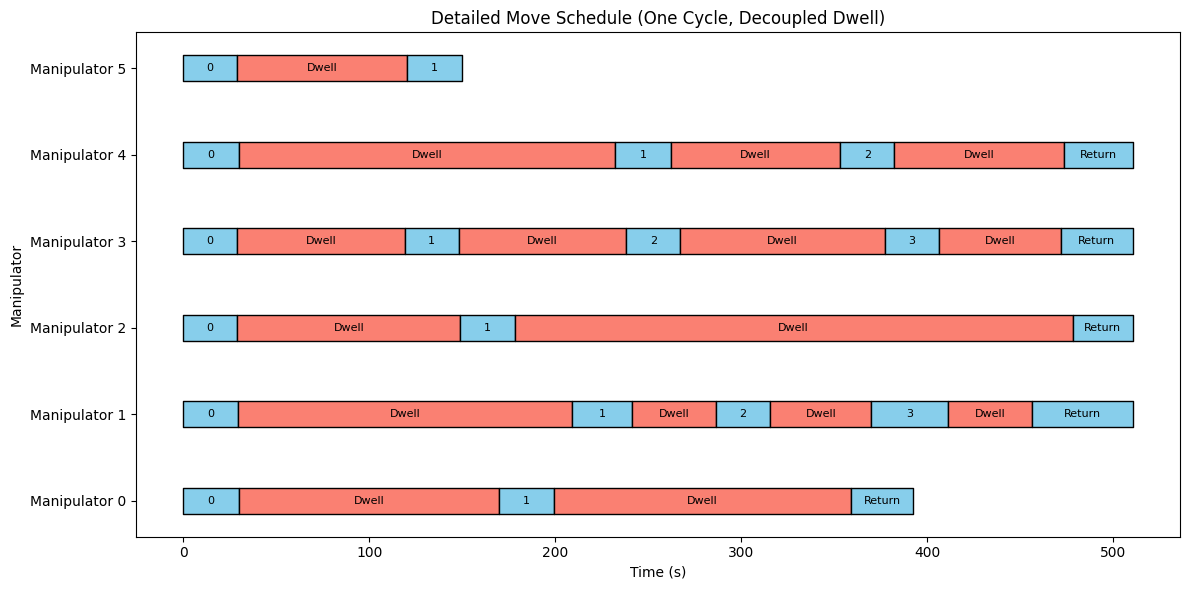

In [8]:
plot_detailed_move_schedule(move_schedule_df)


Corridor ranges by manipulator (auto, based on utilization):
Corridor 1: from bath 1 (op 2) to bath 4 (op 5); Total ideal dwell: 720.00 s
Corridor 2: from bath 4 (op 5) to bath 7 (op 8); Total ideal dwell: 820.00 s
Corridor 3: from bath 7 (op 8) to bath 9 (op 10); Total ideal dwell: 600.00 s
Corridor 4: from bath 9 (op 10) to bath 13 (op 14); Total ideal dwell: 615.00 s
Corridor 5: from bath 13 (op 14) to bath 17 (op 19); Total ideal dwell: 610.00 s
Corridor 6: from bath 17 (op 19) to bath 20 (op 22); Total ideal dwell: 490.00 s

Detailed Simulation Log:
                 task  from_bath  to_bath  bath_id  start_time    end_time  \
42        transfer_in         17       17       17    0.000000    1.000000   
12        transfer_in          7        7        7    0.000000    1.000000   
6         transfer_in          4        4        4    0.000000    1.000000   
28        transfer_in         13       13       13    0.000000    1.000000   
14        transfer_in          9        9        

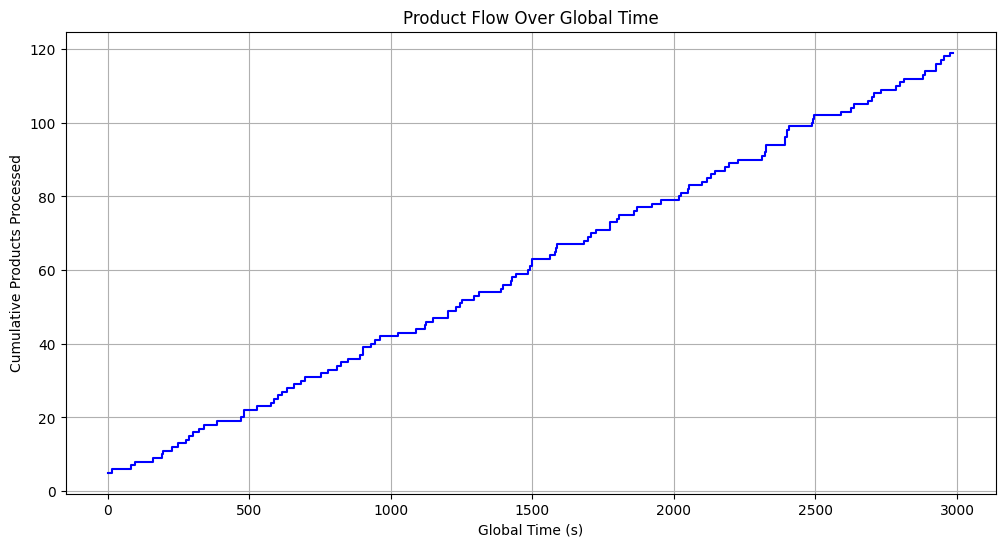

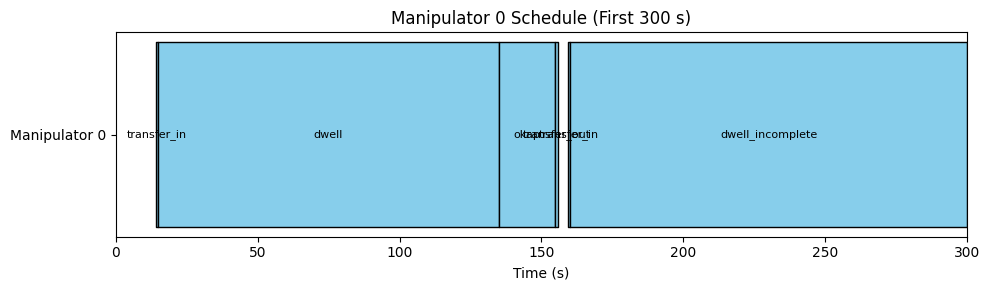

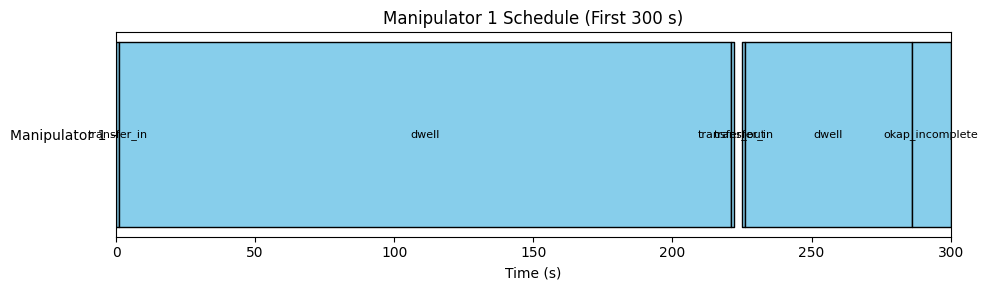

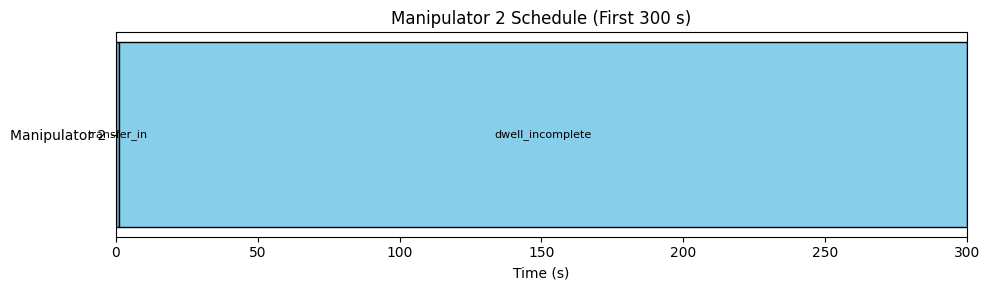

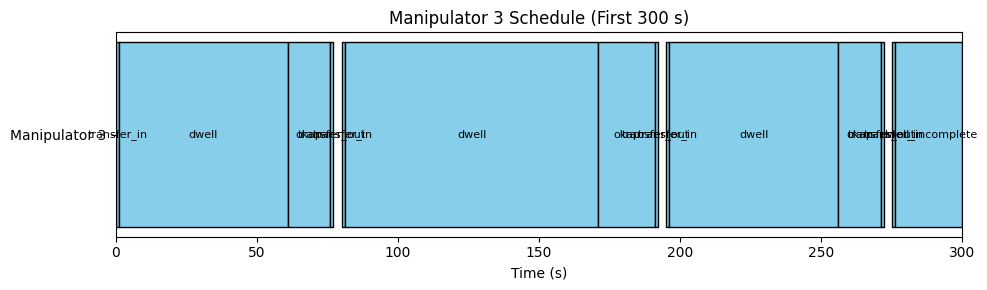

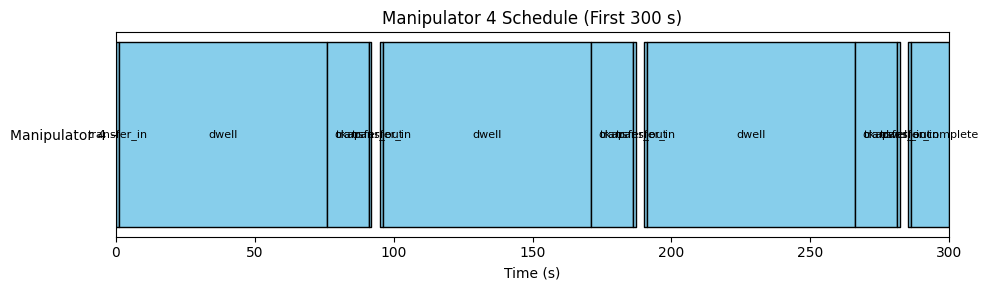

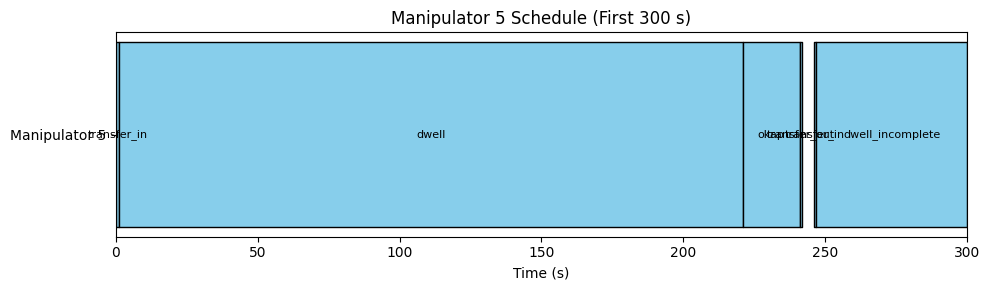

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------ Data Preparation ------------------

def prepare_linka_df(linka_df):
    # Remove rows where id_vany is NaN (e.g., the "vozik" row)
    return linka_df[linka_df["id_vany"].notnull()].copy()

# ------------------ Linear Partitioning ------------------

def linear_partition(seq, k):
    """
    Partition a list of numbers (seq) into k contiguous partitions
    so that the maximum sum over the partitions is minimized.
    Returns a list of lists, each containing indices (0-indexed) for that partition.
    """
    n = len(seq)
    if k <= 0:
        return []
    if k >= n:
        return [[i] for i in range(n)]

    prefix_sum = [0] * (n+1)
    for i in range(1, n+1):
        prefix_sum[i] = prefix_sum[i-1] + seq[i-1]

    dp = [[float('inf')] * (k+1) for _ in range(n+1)]
    dp[0][0] = 0
    dividers = [[0] * (k+1) for _ in range(n+1)]

    for i in range(1, n+1):
        dp[i][1] = prefix_sum[i]
    for j in range(2, k+1):
        for i in range(1, n+1):
            for x in range(j-1, i):
                cost = max(dp[x][j-1], prefix_sum[i] - prefix_sum[x])
                if cost < dp[i][j]:
                    dp[i][j] = cost
                    dividers[i][j] = x

    def traceback(n, k):
        if k == 1:
            return [list(range(0, n))]
        else:
            x = dividers[n][k]
            return traceback(x, k-1) + [list(range(x, n))]
    return traceback(n, k)

# ------------------ Automatic Corridor Segmentation with Overlap ------------------

def segment_operations_by_cost_overlap(tech_recept, num_manipulators, boundaries=None):
    """
    Automatically segment the middle operations (those with id_vany not in [0, 100])
    using linear partitioning on the ideal dwell times (cas_opt). Then force the corridors to overlap
    at the boundaries by including the boundary row in both adjacent segments.

    If boundaries is None, partitions are computed automatically to yield exactly num_manipulators segments.

    Returns a list of DataFrames (one per corridor).
    """
    # Ensure the recipe is sorted by operation order.
    tech_recept = tech_recept.sort_values("poradi_operace").reset_index(drop=True)
    middle_ops = tech_recept[~tech_recept["id_vany"].isin([0, 100])].reset_index(drop=True)
    if boundaries is None:
        # Compute partitions automatically using linear_partition.
        costs = middle_ops["cas_opt"].tolist()
        partitions = linear_partition(costs, num_manipulators)
        segments = []
        for i, part in enumerate(partitions):
            if i > 0:
                # Overlap: include the first row of the current partition in the previous segment.
                segments[-1] = pd.concat([segments[-1], middle_ops.iloc[[part[0]]]])
            segments.append(middle_ops.iloc[part].copy())
        return segments
    else:
        # Use the supplied boundaries list.
        segments = []
        prev = 0
        for b in boundaries:
            segments.append(middle_ops.iloc[prev:b+1].copy())
            prev = b  # Overlap: next segment starts at b.
        segments.append(middle_ops.iloc[prev:].copy())
        return segments

def print_corridor_ranges(segments):
    """
    Print for each corridor the range of bath IDs (first and last) and the total ideal dwell time.
    """
    for i, seg in enumerate(segments):
        if seg.empty:
            print(f"Corridor {i+1}: No operations assigned.")
        else:
            start_op = seg.iloc[0]
            end_op = seg.iloc[-1]
            total_dwell = seg["cas_opt"].sum()
            print(f"Corridor {i+1}: from bath {start_op['id_vany']} (op {start_op['poradi_operace']}) "
                  f"to bath {end_op['id_vany']} (op {end_op['poradi_operace']}); Total ideal dwell: {total_dwell:.2f} s")

# ------------------ Helper Functions for Simulation ------------------

def travel_time(last_pos, curr_pos, speed_left_right):
    """
    Compute travel time (s) between two positions (in mm).
    Formula: time (s) = (|Δ(mm)|/1000) / (speed (m/min)) * 60
    """
    distance_m = abs(curr_pos - last_pos) / 1000.0
    return (distance_m / speed_left_right) * 60.0

def simulate_manipulator_cycle_with_carry(seg, start_time, start_pos, start_bath, home_pos, linka_df, speed, cycle_time=300, service_time=1.0, allow_return_home=False, initial_carry=None):
    """
    Simulate one 300-s cycle for a given corridor (segment).

    If an initial carry (incomplete dwell from a previous cycle) exists (and contains "remaining_dwell"),
    it is processed at the start.

    For each operation in the corridor, the manipulator:
      1. Transfers in (travels to the current bath),
      2. Executes dwell (cas_opt). If time is insufficient, a dwell_incomplete event is recorded and the remainder is carried over,
      3. Executes okap if required,
      4. And then transfers out.

    For manipulator 0, a return_home event to bath 0 is attempted.
    A dummy_wait event is appended if there is leftover time so that the cycle lasts exactly 300 s.

    Returns:
      events: list of event dictionaries (local times within the cycle).
      final_time: local cycle end time (should equal cycle_time).
      end_pos: ending position (mm).
      new_carry: dict for any incomplete dwell (or okap) to be carried over.
    """
    events = []
    t = start_time
    pos = start_pos
    prev_bath_id = start_bath
    new_carry = None

    # Process initial carry if available and with "remaining_dwell"
    if initial_carry is not None and "remaining_dwell" in initial_carry:
        remaining = initial_carry["remaining_dwell"]
        if remaining >= cycle_time:
            events.append({
                "task": "carry_dwell",
                "from_bath": initial_carry["bath_id"],
                "to_bath": initial_carry["bath_id"],
                "bath_id": initial_carry["bath_id"],
                "start_time": 0,
                "end_time": cycle_time,
                "info": f"Carry dwell, {remaining:.2f}s remains (not completed)"
            })
            new_carry = {"bath_id": initial_carry["bath_id"],
                         "remaining_dwell": remaining - cycle_time,
                         "bath_pos": initial_carry["bath_pos"]}
            return events, cycle_time, initial_carry["bath_pos"], new_carry
        else:
            events.append({
                "task": "carry_dwell",
                "from_bath": initial_carry["bath_id"],
                "to_bath": initial_carry["bath_id"],
                "bath_id": initial_carry["bath_id"],
                "start_time": 0,
                "end_time": remaining,
                "info": f"Carry dwell completed, {remaining:.2f}s"
            })
            t = remaining
            pos = initial_carry["bath_pos"]
            prev_bath_id = initial_carry["bath_id"]

    for idx, row in seg.iterrows():
        current_bath_id = row["id_vany"]
        bath_pos = linka_df.loc[linka_df["id_vany"] == current_bath_id, "pozice_x_cum"].values[0]
        t += travel_time(pos, bath_pos, speed)
        events.append({
            "task": "transfer_in",
            "from_bath": prev_bath_id,
            "to_bath": current_bath_id,
            "bath_id": current_bath_id,
            "start_time": t,
            "end_time": t + service_time
        })
        t += service_time
        pos = bath_pos
        prev_bath_id = current_bath_id

        ideal_dwell = float(row["cas_opt"])
        if t + ideal_dwell <= cycle_time:
            events.append({
                "task": "dwell",
                "from_bath": current_bath_id,
                "to_bath": current_bath_id,
                "bath_id": current_bath_id,
                "start_time": t,
                "end_time": t + ideal_dwell
            })
            t += ideal_dwell
        else:
            executed_dwell = cycle_time - t
            remaining_dwell = ideal_dwell - executed_dwell
            events.append({
                "task": "dwell_incomplete",
                "from_bath": current_bath_id,
                "to_bath": current_bath_id,
                "bath_id": current_bath_id,
                "start_time": t,
                "end_time": cycle_time,
                "info": f"Dwell incomplete, {remaining_dwell:.2f}s remains"
            })
            new_carry = {"bath_id": current_bath_id, "remaining_dwell": remaining_dwell, "bath_pos": bath_pos}
            t = cycle_time
            break

        if row["okap"] == 1 and row["okap_cas"] > 0:
            if t + row["okap_cas"] <= cycle_time:
                events.append({
                    "task": "okap",
                    "from_bath": current_bath_id,
                    "to_bath": current_bath_id,
                    "bath_id": current_bath_id,
                    "start_time": t,
                    "end_time": t + row["okap_cas"]
                })
                t += row["okap_cas"]
            else:
                executed_okap = cycle_time - t
                remaining_okap = row["okap_cas"] - executed_okap
                events.append({
                    "task": "okap_incomplete",
                    "from_bath": current_bath_id,
                    "to_bath": current_bath_id,
                    "bath_id": current_bath_id,
                    "start_time": t,
                    "end_time": cycle_time,
                    "info": f"Okap incomplete, {remaining_okap:.2f}s remains"
                })
                new_carry = {"bath_id": current_bath_id, "remaining_okap": remaining_okap, "bath_pos": bath_pos}
                t = cycle_time
                break

        if t + service_time <= cycle_time:
            events.append({
                "task": "transfer_out",
                "from_bath": current_bath_id,
                "to_bath": current_bath_id,
                "bath_id": current_bath_id,
                "start_time": t,
                "end_time": t + service_time
            })
            t += service_time
        else:
            events.append({
                "task": "dummy_move_transfer_out",
                "from_bath": current_bath_id,
                "to_bath": current_bath_id,
                "bath_id": current_bath_id,
                "start_time": t,
                "end_time": cycle_time,
                "info": "Not enough time for transfer_out"
            })
            t = cycle_time
            break

    if allow_return_home and t < cycle_time:
        home_bath_id = 0
        home_pos = linka_df.loc[linka_df["id_vany"] == home_bath_id, "pozice_x_cum"].values[0]
        t_return = travel_time(pos, home_pos, speed)
        if t + t_return <= cycle_time:
            events.append({
                "task": "return_home",
                "from_bath": prev_bath_id,
                "to_bath": home_bath_id,
                "bath_id": home_bath_id,
                "start_time": t,
                "end_time": t + t_return
            })
            t += t_return
            pos = home_pos
        else:
            events.append({
                "task": "dummy_move_return",
                "from_bath": prev_bath_id,
                "to_bath": home_bath_id,
                "bath_id": prev_bath_id,
                "start_time": t,
                "end_time": cycle_time,
                "info": "Not enough time to return home"
            })
            t = cycle_time

    if t < cycle_time:
        events.append({
            "task": "dummy_wait",
            "from_bath": prev_bath_id,
            "to_bath": prev_bath_id,
            "bath_id": prev_bath_id,
            "start_time": t,
            "end_time": cycle_time,
            "info": "Filling cycle with dummy wait"
        })
        t = cycle_time

    return events, t, pos, new_carry

# ------------------ Continuous Simulation ------------------

def generate_continuous_simulation(linka_df, recept_df, manipulator_characteristics, num_manipulators, tech_type, T_total, boundaries=None):
    """
    Simulate the coating line continuously for a total simulation time T_total (seconds).

    The recipe is segmented automatically based on ideal dwell times (cas_opt) and corridors are forced to overlap.
    If boundaries is provided, it is used; otherwise, segmentation is computed automatically.
    The number of corridors will equal num_manipulators.

    Each manipulator repeatedly processes products using its assigned corridor.
    Global times are maintained individually.

    Returns:
      sim_df: DataFrame of all events (with global times).
      throughput: Dictionary with product counts (entry from manipulator 0, exit from the last manipulator).
    """
    all_events = []
    carry_over_dict = {m: None for m in range(num_manipulators)}
    global_times = {m: 0 for m in range(num_manipulators)}
    product_counts = {m: 0 for m in range(num_manipulators)}
    sim_events = []

    tech_recept = recept_df[recept_df["tech"] == tech_type].copy()
    tech_recept.sort_values("poradi_operace", inplace=True)
    tech_recept.reset_index(drop=True, inplace=True)
    segments = segment_operations_by_cost_overlap(tech_recept, num_manipulators, boundaries)
    if len(segments) != num_manipulators:
        raise ValueError(f"Automatic segmentation produced {len(segments)} segments but {num_manipulators} are required.")
    print("Corridor ranges by manipulator (auto, based on utilization):")
    print_corridor_ranges(segments)

    vstup_op = tech_recept[tech_recept["id_vany"] == 0].iloc[0]
    vstup_pos = linka_df.loc[linka_df["id_vany"] == vstup_op["id_vany"], "pozice_x_cum"].values[0]

    while max(global_times.values()) < T_total:
        for m in range(num_manipulators):
            if segments[m].empty:
                events, duration, end_pos, carry = ([{
                    "task": "wait",
                    "bath_id": None,
                    "from_bath": None,
                    "to_bath": None,
                    "start_time": 0,
                    "end_time": T_total - global_times[m],
                    "info": "No operations"
                }], T_total - global_times[m], None, None)
            else:
                if m == 0:
                    start_time = 10.0 if global_times[m] == 0 else 0.0
                    start_pos = vstup_pos
                    start_bath = 0
                    allow_return = True
                else:
                    start_time = 0.0
                    start_bath = segments[m].iloc[0]["id_vany"]
                    start_pos = linka_df.loc[linka_df["id_vany"] == start_bath, "pozice_x_cum"].values[0]
                    allow_return = False
                events, cycle_duration, end_pos, carry = simulate_manipulator_cycle_with_carry(
                    segments[m], start_time, start_pos, start_bath,
                    None,  # Not enforcing return home for intermediate stages
                    linka_df, manipulator_characteristics["speed_left_right"],
                    cycle_time=300, service_time=1.0,
                    allow_return_home=allow_return, initial_carry=carry_over_dict[m]
                )
            global_times[m] += cycle_duration
            product_counts[m] += 1
            for ev in events:
                ev["global_start_time"] = ev["start_time"] + global_times[m] - cycle_duration
                ev["global_end_time"] = ev["end_time"] + global_times[m] - cycle_duration
                ev["manipulator_id"] = m
                ev["product_id"] = product_counts[m]
                sim_events.append(ev)
            carry_over_dict[m] = carry
        if max(global_times.values()) >= T_total:
            break

    sim_df = pd.DataFrame(sim_events)
    sim_df.sort_values("global_start_time", inplace=True)
    throughput = {"ProductIn": product_counts[0], "ProductOut": product_counts[num_manipulators-1]}
    return sim_df, throughput

def print_corridor_ranges(segments):
    for i, seg in enumerate(segments):
        if seg.empty:
            print(f"Corridor {i+1}: No operations assigned.")
        else:
            start_op = seg.iloc[0]
            end_op = seg.iloc[-1]
            total_dwell = seg["cas_opt"].sum()
            print(f"Corridor {i+1}: from bath {start_op['id_vany']} (op {start_op['poradi_operace']}) "
                  f"to bath {end_op['id_vany']} (op {end_op['poradi_operace']}); Total ideal dwell: {total_dwell:.2f} s")

# ------------------ Plot Functions ------------------

def plot_product_flow(sim_df):
    times = sorted(list(set(sim_df["global_start_time"].tolist() + [sim_df["global_end_time"].max()])))
    sim_df["delta"] = sim_df["task"].apply(lambda x: 1 if x=="transfer_in" else 0)
    counts = sim_df.groupby("global_start_time")["delta"].sum().cumsum()
    plt.figure(figsize=(12,6))
    plt.step(counts.index, counts.values, where="post", color="blue")
    plt.xlabel("Global Time (s)")
    plt.ylabel("Cumulative Products Processed")
    plt.title("Product Flow Over Global Time")
    plt.grid(True)
    plt.show()

def plot_detailed_move_schedule_by_manipulator(sim_df, T_plot=300):
    grouped = sim_df.groupby("manipulator_id")
    for m, group in grouped:
        fig, ax = plt.subplots(figsize=(10, 3))
        for idx, row in group.iterrows():
            if row["global_start_time"] < T_plot:
                local_start = row["global_start_time"]
                duration = row["global_end_time"] - row["global_start_time"]
                task = row["task"]
                ax.broken_barh([(local_start, duration)], (0, 5), facecolors="skyblue", edgecolor="black")
                ax.text(local_start + duration/2, 2.5, task, ha="center", va="center", fontsize=8)
        ax.set_xlim(0, T_plot)
        ax.set_xlabel("Time (s)")
        ax.set_yticks([2.5])
        ax.set_yticklabels([f"Manipulator {m}"])
        ax.set_title(f"Manipulator {m} Schedule (First {T_plot} s)")
        plt.tight_layout()
        plt.show()

# ------------------ Main Execution ------------------

tech_type = "tech1"
T_total = 3000   # Total simulation time (seconds)
num_manipulators = 6  # We want 6 corridors


linka_df = prepare_linka_df(linka_df)


recept_df = recept_df[recept_df["id_vany"].notnull()].copy()

# Run the continuous simulation.
sim_df, throughput = generate_continuous_simulation(linka_df, recept_df, manipulator_characteristics, num_manipulators, tech_type, T_total, boundaries=None)
print("\nDetailed Simulation Log:")
print(sim_df)
print("\nThroughput (approximate):")
print(throughput)

# ------------------ Plotting ------------------

def plot_product_flow(sim_df):
    times = sorted(list(set(sim_df["global_start_time"].tolist() + [sim_df["global_end_time"].max()])))
    sim_df["delta"] = sim_df["task"].apply(lambda x: 1 if x=="transfer_in" else 0)
    counts = sim_df.groupby("global_start_time")["delta"].sum().cumsum()
    plt.figure(figsize=(12,6))
    plt.step(counts.index, counts.values, where="post", color="blue")
    plt.xlabel("Global Time (s)")
    plt.ylabel("Cumulative Products Processed")
    plt.title("Product Flow Over Global Time")
    plt.grid(True)
    plt.show()

def plot_detailed_move_schedule_by_manipulator(sim_df, T_plot=300):
    grouped = sim_df.groupby("manipulator_id")
    for m, group in grouped:
        fig, ax = plt.subplots(figsize=(10, 3))
        for idx, row in group.iterrows():
            if row["global_start_time"] < T_plot:
                local_start = row["global_start_time"]
                duration = row["global_end_time"] - row["global_start_time"]
                task = row["task"]
                ax.broken_barh([(local_start, duration)], (0, 5), facecolors="skyblue", edgecolor="black")
                ax.text(local_start + duration/2, 2.5, task, ha="center", va="center", fontsize=8)
        ax.set_xlim(0, T_plot)
        ax.set_xlabel("Time (s)")
        ax.set_yticks([2.5])
        ax.set_yticklabels([f"Manipulator {m}"])
        ax.set_title(f"Manipulator {m} Schedule (First {T_plot} s)")
        plt.tight_layout()
        plt.show()

plot_product_flow(sim_df)
plot_detailed_move_schedule_by_manipulator(sim_df, T_plot=300)


ver2